In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
import os
import time

In [2]:
# 데이터 불러오기
df_normal = pd.read_excel('../dataset/preprocessed/50ohm_정상_train.xlsx')
df_arc = pd.read_excel('../dataset/preprocessed/50ohm_아크_train.xlsx')
test_df = pd.read_excel('../dataset/preprocessed/50ohm_통합_test.xlsx')

df_normal = df_normal.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})
df_arc = df_arc.rename(columns={'arc_voltage': 'voltage', 'arc_current': 'current'})
test_df = test_df.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})

df_normal['label'] = 0
df_arc['label'] = 1

train_df = pd.concat([df_normal, df_arc], ignore_index=True)

In [3]:
def add_features(df):
    df['voltage_diff'] = df['voltage'].diff().fillna(0).abs()
    df['current_diff'] = df['current'].diff().fillna(0).abs()
    df['voltage_ma'] = df['voltage'].rolling(5).mean().bfill()
    df['current_ma'] = df['current'].rolling(5).mean().bfill()
    df['power'] = df['voltage'] * df['current']
    df['power_diff'] = df['power'].diff().fillna(0).abs()
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)

In [4]:
# 피처 설정
features = ['voltage', 'current', 'voltage_diff', 'current_diff',
            'voltage_ma', 'current_ma', 'power', 'power_diff']

X_train = train_df[features].values
y_train = train_df['label'].values
X_test = test_df[features].values
y_test = test_df['label'].values

In [5]:
# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CNN 입력에 맞게 reshape
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

print(X_train_scaled.shape)

(1477, 8, 1)


In [6]:
# CNN 모델 정의
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\NGN Lab\Desktop\kys\논문\전기안전공학\source\arc-detection-project\powerenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# 학습
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train_scaled, y_train, validation_split=0.2,
          epochs=100, batch_size=64, callbacks=[early_stop])

model.save('./model/cnn1d_model.h5')
joblib.dump(scaler, './model/scaler_cnn.joblib')


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5664 - loss: 0.6732 - val_accuracy: 0.6554 - val_loss: 0.6736
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8197 - loss: 0.5397 - val_accuracy: 0.9865 - val_loss: 0.4650
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8928 - loss: 0.4062 - val_accuracy: 0.9865 - val_loss: 0.2756
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8888 - loss: 0.3141 - val_accuracy: 0.9865 - val_loss: 0.2015
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9019 - loss: 0.2456 - val_accuracy: 0.9865 - val_loss: 0.1247
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9233 - loss: 0.2044 - val_accuracy: 0.9932 - val_loss: 0.0871
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9431 - loss: 0.1715 - val_accuracy: 1.0000 - val_loss: 0.0652
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9747 - loss: 0.1391 - val_accuracy: 1.000

['./model/scaler_cnn.joblib']

In [8]:
# 학습했던 .h5 모델 불러오기
model = tf.keras.models.load_model('./model/cnn1d_model.h5')

# TensorFlow Lite 모델로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델 저장
with open('./model/cnn1d_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ 변환 완료! cnn1d_model.tflite 생성 완료.")

INFO:tensorflow:Assets written to: C:\Users\NGNLAB~1\AppData\Local\Temp\tmp3wjo9x8r\assets


INFO:tensorflow:Assets written to: C:\Users\NGNLAB~1\AppData\Local\Temp\tmp3wjo9x8r\assets


Saved artifact at 'C:\Users\NGNLAB~1\AppData\Local\Temp\tmp3wjo9x8r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2425727136400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425727131792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425727136592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425727135632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425727135440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425727137360: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ 변환 완료! cnn1d_model.tflite 생성 완료.


In [9]:
# 예측
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob.flatten() > 0.0555).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [10]:
def postprocess_anomalies(y_pred_bin, min_consecutive=8):
    y_post = np.zeros_like(y_pred_bin)
    count = 0
    for i, val in enumerate(y_pred_bin):
        if val == 1:
            count += 1
        else:
            if count >= min_consecutive:
                y_post[i - count:i] = 1
            count = 0
    if count >= min_consecutive:
        y_post[len(y_pred_bin)-count:] = 1
    return y_post

y_pred_post = postprocess_anomalies(y_pred, min_consecutive=8)
y_true_post = postprocess_anomalies(y_test, min_consecutive=8)

In [11]:
print("📋 (후처리 적용) 분류 리포트:\n")
print(classification_report(y_true_post, y_pred_post, target_names=['정상', '아크']))

📋 (후처리 적용) 분류 리포트:

              precision    recall  f1-score   support

          정상       0.95      1.00      0.97       480
          아크       1.00      0.59      0.75        64

    accuracy                           0.95       544
   macro avg       0.97      0.80      0.86       544
weighted avg       0.95      0.95      0.95       544



In [12]:
def calculate_detection_delay(y_pred_bin, label, sampling_interval=0.0001):
    arc_start = np.where(label == 1)[0][0]
    detected = np.where(y_pred_bin[arc_start:] == 1)[0]
    if len(detected) == 0:
        print("⚠️ 아크를 탐지하지 못했습니다.")
        return None
    detect_index = detected[0] + arc_start
    delay = detect_index - arc_start
    time_detected = detect_index * sampling_interval
    print(f"✅ 아크 시작 인덱스: {arc_start}")
    print(f"✅ 모델 이상 감지 인덱스: {detect_index}")
    print(f"⏱️ 감지 지연 시간: {delay} 샘플")
    print(f"⏱️ 감지된 시점 (초): {time_detected:.6f} 초")
    return arc_start, detect_index, delay

arc_start, detect_index, delay = calculate_detection_delay(y_pred_post, y_true_post)


✅ 아크 시작 인덱스: 240
✅ 모델 이상 감지 인덱스: 264
⏱️ 감지 지연 시간: 24 샘플
⏱️ 감지된 시점 (초): 0.026400 초


In [13]:
# 전체 예측 시간
start_total = time.perf_counter()
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob.flatten() > 0.5).astype(int)
elapsed_total = time.perf_counter() - start_total
print(f"⏱️ 전체 예측 소요 시간: {elapsed_total:.10f}초")

# 후처리 + 첫 이상 감지까지 시간
start_first = time.perf_counter()
y_pred_post = postprocess_anomalies(y_pred, min_consecutive=8)
first_index = np.where(y_pred_post == 1)[0]
elapsed_first = time.perf_counter() - start_first

if len(first_index) > 0:
    print(f"🟡 첫 번째 이상 탐지 인덱스: {first_index[0]}")
    print(f"⏱️ 첫 이상 탐지까지 걸린 시간: {elapsed_first:.10f}초")
else:
    print("⚠️ 후처리된 이상 탐지 결과가 없습니다.")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
⏱️ 전체 예측 소요 시간: 0.2386002000초
🟡 첫 번째 이상 탐지 인덱스: 266
⏱️ 첫 이상 탐지까지 걸린 시간: 0.0004229000초


In [14]:
# 모듈 임포트
import psutil
import os

# 리소스 사용량 출력 함수
def print_resource_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    cpu_percent = process.cpu_percent(interval=1.0)
    print(f"🧠 메모리 사용량: {mem_info.rss / 1024 ** 2:.2f} MB")
    print(f"🧮 CPU 사용률: {cpu_percent:.2f}%")


# 전체 예측 시간 측정 + 시스템 리소스 출력
print("🔍 예측 전 시스템 상태:")
print_resource_usage()

start_total = time.perf_counter()
y_pred = model.predict(X_test_scaled)
elapsed_total = time.perf_counter() - start_total

print("🔍 예측 후 시스템 상태:")
print_resource_usage()

print(f"⏱️ 전체 예측 소요 시간: {elapsed_total:.10f}초")



🔍 예측 전 시스템 상태:
🧠 메모리 사용량: 499.87 MB
🧮 CPU 사용률: 0.00%
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
🔍 예측 후 시스템 상태:
🧠 메모리 사용량: 499.88 MB
🧮 CPU 사용률: 0.00%
⏱️ 전체 예측 소요 시간: 0.1355578000초


---
# 시각화

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic'   # macOS 사용자
# plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (Nanum 폰트 설치 필요)

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

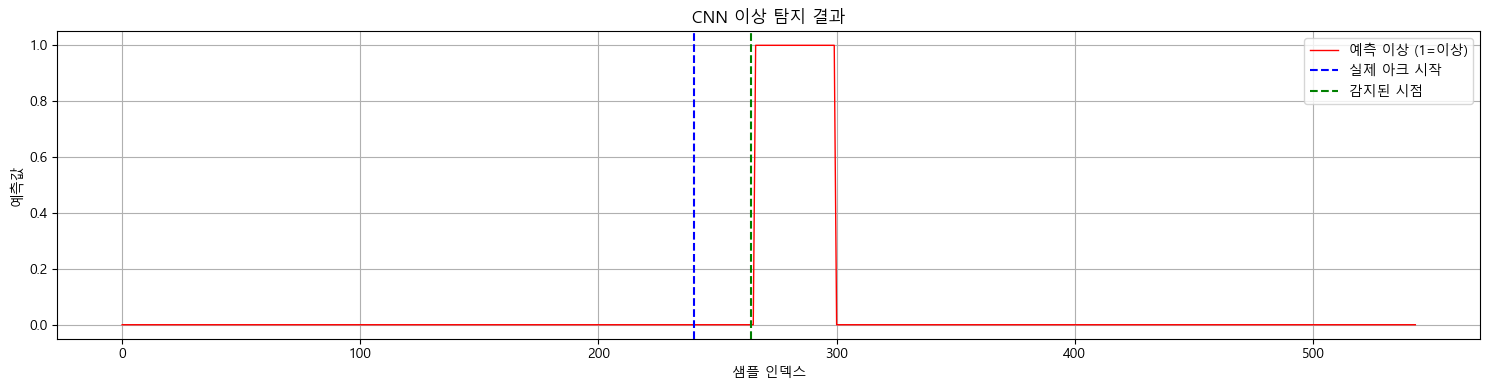

In [16]:
def plot_predictions(y_pred_bin, arc_start=None, detect_index=None):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='예측 이상 (1=이상)', color='red', linewidth=1)

    if arc_start is not None:
        plt.axvline(x=arc_start, color='blue', linestyle='--', label='실제 아크 시작')
    if detect_index is not None:
        plt.axvline(x=detect_index, color='green', linestyle='--', label='감지된 시점')

    plt.title("CNN 이상 탐지 결과")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("예측값")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(y_pred_post, arc_start, detect_index)


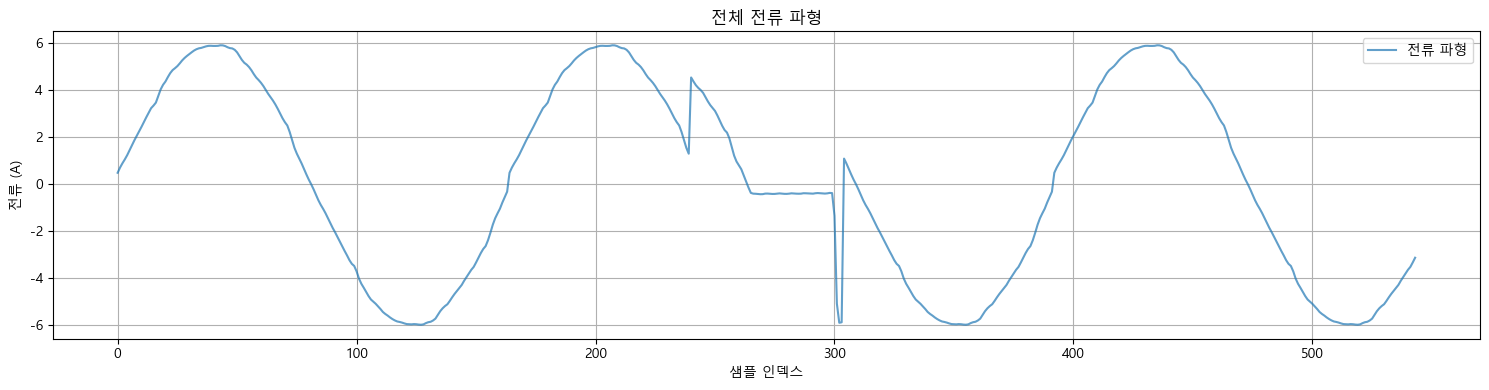

In [17]:
def plot_current_waveform(test_df):
    plt.figure(figsize=(15, 4))
    plt.plot(test_df['current'], label='전류 파형', alpha=0.7)
    plt.title("전체 전류 파형")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("전류 (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_current_waveform(test_df)

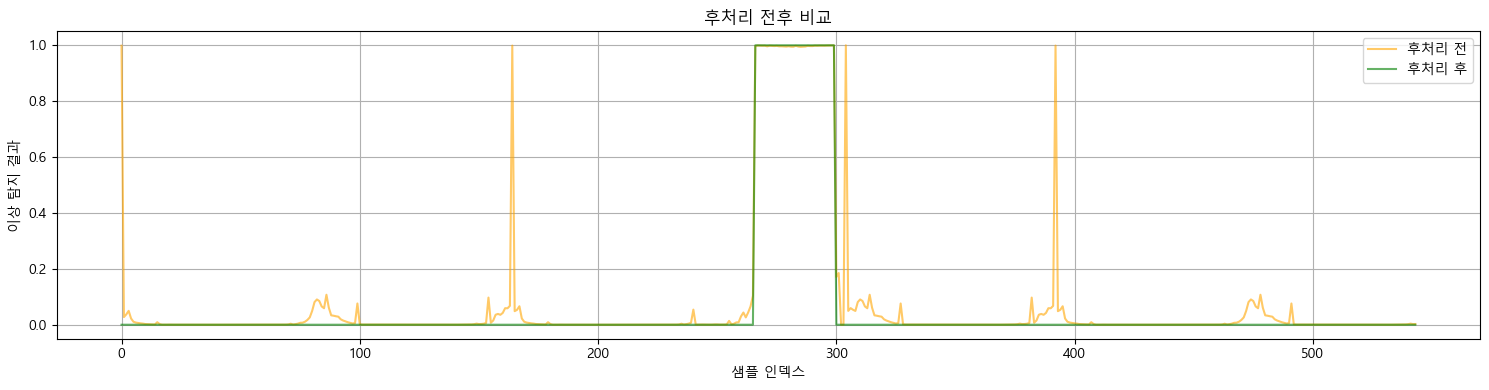

In [18]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_pred, y_pred_post)




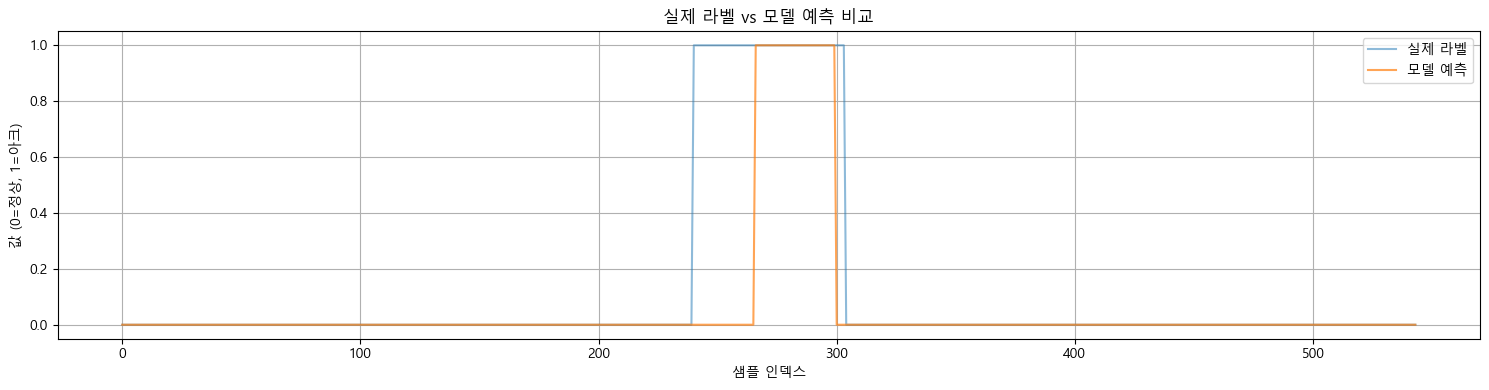

In [19]:
def compare_prediction_vs_label(y_true, y_pred_post):
    plt.figure(figsize=(15, 4))
    plt.plot(y_true, label='실제 라벨', alpha=0.5)
    plt.plot(y_pred_post, label='모델 예측', alpha=0.7)
    plt.title("실제 라벨 vs 모델 예측 비교")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("값 (0=정상, 1=아크)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_prediction_vs_label(y_true_post, y_pred_post)

# # 차이점 위치 찾기
# mismatch_indices = np.where(y_true_post != y_pred_post)[0]
# print("불일치 인덱스:", mismatch_indices)
# print("불일치 개수:", len(mismatch_indices))